# Imports and setup

In [1]:
import sys, os
sys.path.append(os.path.realpath(".."))
os.environ["EEG_ROOT"] = "/home/ms994"
import util_funcs
from importlib import reload
reload(util_funcs)
from copy import deepcopy as cp

import data_reader as read
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import pywt
import tsfresh.feature_extraction.feature_calculators as feats
import constants
import clinical_text_analysis as cta
import tsfresh
import ensembleReader as er
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve, r2_score
from os import path

import wf_analysis.datasets as wfdata
import wf_analysis.filters as filt
from addict import Dict
import time
import pickle as pkl
import tsfresh.feature_extraction.feature_calculators as tsf
import pyedflib as edf
import seaborn as sns
import multiprocessing as mp
import numpy.random as random
import statsmodels

import keras_models.dataGen as dg

Using Theano backend.


In [14]:
[(util_funcs.get_common_channel_names().index("EEG {}-REF".format(montage[:montage.index("-")])), util_funcs.get_common_channel_names().index("EEG {}-REF".format(montage[montage.index("-") + 1:]))) for montage in constants.MONTAGE_COLUMNS]

[(1, 6),
 (6, 10),
 (16, 14),
 (4, 12),
 (14, 18),
 (10, 12),
 (20, 13),
 (0, 11),
 (10, 3),
 (5, 1),
 (18, 0),
 (2, 18),
 (12, 8),
 (20, 4),
 (16, 5),
 (18, 1),
 (1, 9),
 (12, 19),
 (3, 7),
 (9, 11),
 (19, 7),
 (13, 10)]

In [15]:
len(util_funcs.get_common_channel_names())

21

In [ ]:
reader = read.EdfDataset("train", "01_tcp_ar", use_numpy=True, n_process=2)

# List of ideas to try out
Longer sequences. It appears that human observers are looking at up to 10+ minutes of EEG data at a time, im only doing 4 second windows in isolation.

See first with hand engineered FFT and coherence features

Also see if i can't include sequences of outputs i.e. t

## Try just doing FNSZ and GNSZ seizure types

## Long sequence

### FFT + Coherence

In [ ]:
fft = read.EdfFFTDatasetTransformer(reader, is_pandas_data=False, freq_bins=constants.FREQ_BANDS, window_size=pd.Timedelta(seconds=0.5), )

In [ ]:
fftData = fft[0][0]

In [ ]:
fftData.shape

In [ ]:
coherenceReader = wfdata.CoherenceTransformer(reader, is_pandas=False)

### labels

In [ ]:
%%bash
cat /home/ms994/v1.5.0/edf/dev_test/01_tcp_ar/002/00000258/s002_2003_07_21/00000258_s002_t002.lbl

In [ ]:
fn = "/home/ms994/v1.5.0/edf/dev_test/01_tcp_ar/002/00000258/s002_2003_07_21/00000258_s002_t002.edf"
fn[:-4]+".lbl"


##### TODO
check that each lbl file has only one level
check that each lbl file is consistent with the tse file

In [ ]:
fn = "/home/ms994/v1.5.0/edf/dev_test/01_tcp_ar/002/00000258/s002_2003_07_21/00000258_s002_t002.lbl"
def get_per_channel_annotation(fn):
    with open(fn, "rb") as  open_label_file:
        output = open_label_file.readlines()
    montage_channel_dict = {}
    start_montage_channel_assign = False
    symbols = [None]
    symbols_list = []
    full_list = []
    for line in output:
        if "montage = 0" in str(line):
            start_montage_channel_assign = True
        if start_montage_channel_assign:
            if b'\n' == (line):
                start_montage_channel_assign = False
            else:
                montage_channel_dict[int(line[10:str(line).index(',') - 2])] = (line[str(line).index(','):str(line).index(':') - 2]).decode("utf-8") 
        elif "symbols[0]" in str(line):
            #since we are using weird pseudocode, run the string through exec and get the symbols variable out
            exec(line.decode("utf8"))
            symbols_dict = symbols
            symbols_list = [symbols_dict[0][i] for i in range(len(symbols[0].keys()))]
    #         print(symbols_list)
        elif "label =" in str(line):
#             print(line.decode("utf8").replace("{", "[").replace("}", "]"))
            #since we are using weird pseudocode, run the string through exec and get the label variable out
            label = eval(line.decode("utf8").replace("{", "[").replace("}", "]")[7:])
            
            curr_level = label[0]
            curr_sublevel = label[1]
            curr_start = label[2]
            curr_end = label[3]
            curr_mont_num = label[4]
            curr_channel = montage_channel_dict[int(curr_mont_num)]
            curr_label_probs = label[5]
            curr_vals = pd.Series([curr_level, curr_sublevel, curr_start, curr_end, curr_channel, *curr_label_probs], index=["level", "sublevel", "start", "end", "channel", *symbols_list])
            full_list.append(curr_vals)
#             del label


    return pd.concat(full_list, axis=1).T

In [ ]:
data = get_per_channel_annotation(fn)
data

In [ ]:
def gen_seizure_channel_labels(fn, width=pd.Timedelta(seconds=0.5)):
    data = get_per_channel_annotation(fn)
    max_time = pd.Timedelta(seconds=int(data.end.max()))
    index = pd.timedelta_range(start=pd.Timedelta(0), end=max_time, freq=width)
    columns = data.channel.unique()
    expanded_is_seizure = pd.DataFrame(index=index, columns=columns).fillna(0)
    for i, row in data.iterrows():
        expanded_is_seizure.loc[pd.Timedelta(seconds=row.start):pd.Timedelta(seconds=row.end), row.channel] = 1 - row.bckg
    return expanded_is_seizure

In [ ]:
edf_files = read.get_all_token_file_names("train", "01_tcp_ar")
reload(read)
lbl_files = [read.get_associated_lbl(fn) for fn in edf_files]

In [ ]:
all_channels = set()
len_channels = set()
for lbl_fn in lbl_files:
    all_channels = all_channels.union(read.get_per_channel_annotation(lbl_fn).channel.unique())
    len_channels.add(len(read.get_per_channel_annotation(lbl_fn).channel.unique()))

In [ ]:
edf_files = read.get_all_token_file_names("dev_test", "01_tcp_ar")
reload(read)
lbl_files = [read.get_associated_lbl(fn) for fn in edf_files]
for lbl_fn in lbl_files:
    all_channels = all_channels.union(read.get_per_channel_annotation(lbl_fn).channel.unique())
    len_channels.add(len(read.get_per_channel_annotation(lbl_fn).channel.unique()))

In [ ]:
list(all_channels)

In [ ]:
list(len_channels)

In [ ]:
util_funcs.get_common_channel_names()

In [ ]:
gen_seizure_channel_labels(fn).columns

In [ ]:
data_x = reader[0][0]

In [ ]:
constants.COMMON_DELTA

### Data Binning

In [ ]:
def time_distribute_x(data_x, width=pd.Timedelta(seconds=4), stride=pd.Timedelta(seconds=1)):
    time_steps = []
    literal_width = int(width/pd.Timedelta(seconds=constants.COMMON_DELTA))
    literal_stride = int(stride/pd.Timedelta(seconds=constants.COMMON_DELTA))
    for i in range(int(data_x.shape[0]/literal_stride - width/stride)):
        time_steps.append(data_x[i*literal_stride:(i) * literal_stride + literal_width])
    time_steps = np.array(time_steps)
    return time_steps

In [ ]:
time_distribute_x(data_x).shape

In [ ]:
len(reader.edf_tokens)

In [ ]:
modify_self()

In [ ]:
class LSTMDataset(util_funcs.MultiProcessingDataset):
    def __init__(self, reader, width=pd.Timedelta(seconds=4), stride=pd.Timedelta(seconds=2)):
        self.width = width
        self.stride = stride
        self.reader = reader
    def __len__(self):
        return len(self.reader)
    def __getitem__(self, i):
        if self.should_use_mp(i):
            return self.getItemSlice(i)
        data_x, labels = self.reader[i]
        data_x = read.time_distribute_x(data_x, width=self.width, stride=self.stride)
        return data_x, read.expand_tse_file_seizure_only(labels, time_period=self.stride).iloc[0:data_x.shape[0]]
        

In [ ]:
reload(read)
reload(lstm_model)
import keras_models.LSTMModels as lstm_model
lstm_data = lstm_model.LSTMDataset(reader)

In [ ]:
reader[10][0].shape

In [ ]:
150240/(250)/60

In [ ]:
dp = lstm_data[10]

In [ ]:
dp[0].shape

In [ ]:
import sys

sys.getsizeof(data[0])

In [ ]:
stride = lstm_data.stride
labels = reader[0][1]
index = pd.timedelta_range(start=pd.Timedelta(0), end=pd.Timedelta(seconds=labels.end.max()), freq=stride)


In [ ]:
reload(read)
seiz_series = read.expand_tse_file_seizure_only(labels)

# CNN + LSTM

In [ ]:
from keras import optimizers
from keras.layers import Masking, Dense, TimeDistributed, Input, Reshape, Dropout, LSTM, Flatten, MaxPool2D, Concatenate, CuDNNLSTM, Conv2D, BatchNormalization
from keras.models import Model, load_model
from keras.utils import multi_gpu_model

In [ ]:
x = Input(shape=(None, 1000, 21, 1))
y = x
# y = Masking(edg.mask_value)(y)
for i in range(6):
    y = TimeDistributed(BatchNormalization())(y)
    y = TimeDistributed(Conv2D(1, (4,4), activation="relu"))(y)
    y = TimeDistributed(MaxPool2D((2,1)))(y)
y = Reshape((-1, y.shape[2].value * y.shape[3].value * y.shape[4].value))(y)
y = CuDNNLSTM(y.shape[-1].value, return_sequences=True)(y)
for i in range(1):
    y = TimeDistributed(Dense(y.shape[-1].value, activation="relu"))(y)
    y = TimeDistributed(Dropout(0.5))(y)
y = TimeDistributed(Dense(2, activation="relu"))(y)
y = Reshape((-1, 2, 1))(y)


model = Model(inputs=x, outputs=[y])
model.summary()

In [ ]:
lstm_data[10][0].shape

In [ ]:
lstm_data.use_mp = False

In [ ]:
reload(dg)
edg = dg.EdfDataGenerator(lstm_data, batch_size=16, n_classes=2, class_type="custom")
edg.transform_y = lambda ys: dg.three_dim_pad([y.values for y in ys], mask_value=edg.mask_value)

In [ ]:
batch_1 = edg[0]

In [ ]:
edg[0]

In [ ]:
model.compile("adam", loss="binary_crossentropy")
history = model.fit_generator(edg, steps_per_epoch=100, use_multiprocessing=True, workers=5, max_queue_size=4)

In [ ]:
history.history

In [ ]:
batch = edg[0]

In [ ]:
lstm_data[1613][1].shape

In [ ]:
batch[1].shape

# Try doing some hand engineered features

## Try pulling debug data and doing the hand-engineered features

In [ ]:
debug_train = pkl.load(open("/home/ms994/debug_train_multiple_labels_seizure_data_4.pkl", "rb"))

In [ ]:
debug_train[0]

In [ ]:
fftData = read.EdfFFTDatasetTransformer(debug_train, is_tuple_data=True, is_pandas_data=False, freq_bins=constants.FREQ_BANDS, window_size=pd.Timedelta(seconds=0.5), )

In [ ]:
fftData[10].transpose((1, 0,2)).shape

In [ ]:
fftData[0].

In [ ]:
coherData.edfRawData[0][0].shape

In [ ]:
reload(wfdata)
coherData = wfdata.CoherenceTransformer(debug_train, is_pandas=False, is_tuple_data=True, average_coherence=False, coherence_bin=pd.Timedelta(seconds=0.5))

In [ ]:
np.hstack([coherData[10][0], fftData[10][0].transpose((1, 0,2)).reshape((8, 21*4))]).shape

In [ ]:
from scipy.signal import coherence

In [ ]:
coherence(coherData.edfRawData[10][0][0:500,0], coherData.edfRawData[10][0][0:500,2])[1]

In [ ]:
plt.subplot(2,1,1)
plt.plot(coherData.edfRawData[10][0][0:250,0])
plt.subplot(2,1,2)

plt.plot(coherData.edfRawData[10][0][0:250,1])


In [ ]:
datum

In [ ]:
coherData[0].shape

In [ ]:
fftData[0].shape

In [ ]:
wfdata.ConcatenationDataset([fftData, coherData])[1]

In [ ]:
coherData.coherence_bin / pd.Timedelta(seconds=constants.COMMON_DELTA)

In [ ]:
debug_train[0][0].shape

# Try to do some analysis on the data we process from the old multilabel script

In [ ]:
import pickle as pkl
train_data = pkl.load(open("/n/scratch2/ms994/processed_train_multiple_labels_seizure_data_4.pkl", "rb"))
valid_data = pkl.load(open("/n/scratch2/ms994/processed_valid_multiple_labels_seizure_data_4.pkl", "rb"))
test_data = pkl.load(open("/n/scratch2/ms994/processed_test_multiple_labels_seizure_data_4.pkl", "rb"))

In [ ]:
train_data[0][0].shape

In [ ]:
from keras import layers
from keras import Model
from keras import optimizers

In [ ]:
x = layers.Input((8,99))
y = x
y = layers.TimeDistributed(layers.Dense(100))(y)
# y = layers.TimeDistributed(layers.Dropout(0.5))(y)

for i in range(2):
    y = layers.CuDNNLSTM(100, return_sequences=True)(y)
    y = layers.Dropout(0.5)(y)
y = layers.CuDNNLSTM(100)(y)
for i in range(2):
    y = layers.Dense(100, activation="relu")(y)
    y = layers.Dropout(0.5)(y)
y = layers.Dense(2, activation="softmax")(y)

In [ ]:
model = Model(input=x, outputs=y)

In [ ]:
model.summary()

In [ ]:
train_data_x = [datum[0] for datum in train_data]
train_data_y = [datum[1][0] for datum in train_data]

In [ ]:
valid_data_x = [datum[0] for datum in valid_data]
valid_data_y = [datum[1][0] for datum in valid_data]

In [ ]:
test_data_x = [datum[0] for datum in test_data]
test_data_y = [datum[1][0] for datum in test_data]

In [ ]:
from keras_models.metrics import f1

In [ ]:
model.compile(optimizers.Adam(0.0005), loss="categorical_crossentropy", metrics=["binary_accuracy", f1])

In [ ]:
import tensorflow as tf
tf.test.is_gpu_available() # True/False

In [ ]:
train_data_y[0]

In [ ]:
from keras.utils import to_categorical

In [ ]:
reload(dg)
hand_eng_edg = dg.HackDataGenNoChannels(dg.RULEdfDataGenerator(train_data_x, labels=train_data_y, n_classes=2, xy_tuple_form=False, separate_x_y=True, precache=True, batch_size=128))
hand_eng_valid_edg = dg.HackDataGenNoChannels(dg.RULEdfDataGenerator(valid_data_x, labels=valid_data_y, n_classes=2, xy_tuple_form=False, separate_x_y=True, precache=True, batch_size=128))
hand_eng_test_edg = dg.HackDataGenNoChannels(dg.EdfDataGenerator(test_data_x, labels=test_data_y, n_classes=2, xy_tuple_form=False, separate_x_y=True, precache=True, batch_size=128))


In [ ]:
valid_edg[0][0].shape

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
edg.datagenObj.dataset

In [ ]:
history = model.fit_generator(edg, validation_data=valid_edg, steps_per_epoch=len(edg), callbacks=[ModelCheckpoint("lstm_test.h5", save_best_only=True, ), EarlyStopping(patience=5)], epochs=100)

In [ ]:
from keras.models import load_model

In [ ]:
model = load_model("lstm_test.h5", compile=False)

In [ ]:
prediction = model.predict(np.array(test_data_x))

In [ ]:
argMaxPred = prediction.argmax(-1)

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score, classification_report, log_loss

In [ ]:
print(classification_report(argMaxPred, test_data_y))

In [ ]:
history.history

# try raw data and hand engineered stuff together???

In [ ]:
# raw_train_data = pkl.load(open("/n/scratch2/ms994/train_multiple_labels_sessions_montage_seizure_data_4.pkl", "rb"))
# raw_valid_data = pkl.load(open("/n/scratch2/ms994/valid_multiple_labels_sessions_montage_seizure_data_4.pkl", "rb"))
raw_test_data = pkl.load(open("/n/scratch2/ms994/test_multiple_labels_sessions_montage_seizure_data_4.pkl", "rb"))

In [ ]:
raw_train_data[0][1]

In [ ]:
len(train_data)

In [ ]:
len(raw_train_data)

In [ ]:
raw_train_y = [datum[1][0] for datum in raw_train_data]

In [ ]:
raw_train_y == train_data_y

In [ ]:
#lstm using the hand engineered features
x_hand_engineered = layers.Input((8,99), name="hand_engineer_input")
y = x_hand_engineered
y = layers.TimeDistributed(layers.Dense(100))(y)
# y = layers.TimeDistributed(layers.Dropout(0.5))(y)

for i in range(2):
    y = layers.CuDNNLSTM(100, return_sequences=True)(y)
    y = layers.Dropout(0.5)(y)
y = layers.CuDNNLSTM(100)(y)
for i in range(2):
    y = layers.Dense(100, activation="relu")(y)
    y = layers.Dropout(0.5)(y)
y_hand_engineered = y

In [ ]:
#cnn for the raw features
x_raw = layers.Input((1000, 21, 1), name="raw_input")
y = x_raw
y = layers.GaussianNoise(1)(y)
for i in range(6):
    y = layers.BatchNormalization()(y)
    y = layers.Convolution2D(4, (4,4), activation="relu")(y)
    y = layers.MaxPool2D((2,1))(y)
# y = layers.Reshape((y.o))
# y = layers.CuDNNLSTM(100)(y)
y_raw_output = layers.Flatten()(y)

In [ ]:
y_concatenate = layers.Concatenate()([y_hand_engineered, y_raw_output])

In [ ]:
y = y_concatenate
for i in range(3):
    y = layers.Dense(100, activation="relu")(y)
    y = layers.Dropout(0.5)(y)

In [ ]:
y_seizure = layers.Dense(2, activation="softmax", name="seizure")(y)
y_subtype = layers.Dense(len(constants.SEIZURE_SUBTYPES), activation="softmax", name="subtype")(y)

In [ ]:
model = Model(inputs=[x_raw, x_hand_engineered], outputs=[y_seizure, y_subtype])

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer=optimizers.Adam(0.0005), loss=["categorical_crossentropy", "categorical_crossentropy"], loss_weights=[1,1], metrics=["categorical_accuracy", f1])

In [ ]:
def drop_patient(data):
    new_data = []
    for datum in data:
        new_data.append((datum[0], (datum[1][0], datum[1][2])))
    return new_data

In [ ]:
drop_patient_train = drop_patient(raw_train_data)
drop_patient_valid = drop_patient(raw_valid_data)
drop_patient_test = drop_patient(raw_test_data)


In [ ]:
raw_train_edg = dg.RULDataGenMultipleLabels(drop_patient_train, labels=([datum[1][0] for datum in drop_patient_train], [datum[1][1] for datum in drop_patient_train]), num_labels=2, n_classes=(2,11), xy_tuple_form=True, precache=True, batch_size=128)
raw_valid_edg = dg.RULDataGenMultipleLabels(drop_patient_valid, labels=([datum[1][0] for datum in drop_patient_valid], [datum[1][1] for datum in drop_patient_valid]), num_labels=2, n_classes=(2,11), xy_tuple_form=True, precache=True, batch_size=128)

In [ ]:
reload(dg)

In [ ]:
rescale_raw_train = dg.RescaleGenerator(raw_train_edg)
rescale_raw_valid = dg.RescaleGenerator(raw_valid_edg)

In [ ]:
reload(dg)
train_edg = dg.ConcatenateGenerator([rescale_raw_train, hand_eng_edg])
valid_edg = dg.ConcatenateGenerator([rescale_raw_valid, hand_eng_valid_edg])

In [ ]:
train_edg[0][0][1].shape

In [ ]:
history = model.fit_generator(train_edg, validation_data=valid_edg, epochs=100, callbacks=[ModelCheckpoint("raw_hand_model.h5", save_best_only=True), EarlyStopping(patience=5)])

In [ ]:
history.history.keys()

In [ ]:
plt.plot(history.history["seizure_loss"])
plt.plot(history.history["val_seizure_loss"])
plt.legend(["train", "valid"])

In [ ]:
from keras.models import load_model
model = load_model("raw_hand_model.h5", compile=False)

In [ ]:
raw_test_data[0]

In [ ]:
pred = model.predict([np.array([datum[0] for datum in raw_test_data]).reshape((130663, 1000,21,1)), np.array(test_data_x)])

In [ ]:
from sklearn.metrics import f1_score, classification_report

In [ ]:
print(classification_report(test_data_y, pred[0].argmax(-1),))bbb

In [ ]:
pred[0].argmax(-1).shapeb

# look at montage

In [2]:
data = pkl.load(open("/n/scratch2/ms994/valid_multiple_labels_sessions_montage_seizure_data_4.pkl", "rb"))

In [8]:
all_equal = [(datum[1][3].iloc[0] == datum[1][3]).all()  for datum in data]

In [11]:
sum(all_equal)/len(all_equal)

0.9561379702503263

In [12]:
all_seizure = [(1 == datum[1][3]).all()  for datum in data]

In [13]:
sum(all_seizure)/len(all_seizure)

0.0027009912250093695

In [14]:
all_healthy = [(0 == datum[1][3]).all()  for datum in data]

In [15]:
sum(all_healthy)/len(all_healthy)

0.953436979025317

In [18]:
partial = [not (datum[1][3].iloc[0] == datum[1][3]).all()  for datum in data]

In [19]:
sum(partial)/len(partial)

0.04386202974967368

In [21]:
proportion_seizure = [datum[1][3].sum()/22 for datum in data]

(array([7.4016e+04, 8.4500e+02, 3.6000e+02, 7.9500e+02, 5.0500e+02,
        6.1000e+01, 6.0000e+01, 4.7000e+01, 6.8000e+01, 6.2200e+02]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

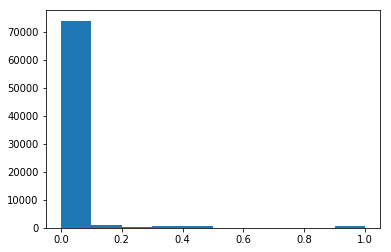

In [23]:
plt.hist(proportion_seizure, bin)